# <font color = green>In this notebook we'll build a model based on RdKit fingerprints</font>
* Dataset is still unbalanced.
* First we'll build a model on imbalanced dataset, then we'll balance the dataset and build the model again

In [1]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sklearn.ensemble
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error

from rdkit import Chem, DataStructs
import rdkit.Chem as rkc
import rdkit.Chem.AllChem as rkac
import rdkit.Chem.Scaffolds.MurckoScaffold as mrks
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Avalon import pyAvalonTools

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is A29E-1842

 Directory of C:\Users\Ankit\Desktop\Project_work

13-05-2024  22:57    <DIR>          .
13-05-2024  19:24    <DIR>          ..
13-05-2024  19:24    <DIR>          .ipynb_checkpoints
13-05-2024  22:52         4,551,921 1_uM_Muski.ipynb
13-05-2024  22:57         6,619,774 3_Final_dataset_notebook.ipynb
01-05-2024  00:47           255,907 4_model_building.ipynb
01-05-2024  16:15             7,732 active_molecules.csv
13-05-2024  22:38            10,805 clean_df_uM.csv
01-05-2024  01:11            90,678 combined_predictions.csv
30-04-2024  22:43               262 enc.pickle
30-04-2024  22:50             4,374 Final_dataframe_encoded.csv
13-05-2024  22:40             5,968 final_dataset_encoded.csv
30-04-2024  23:40            22,470 knn_model_25.pkl
01-05-2024  01:03            30,228 knn_predictions.csv
13-05-2024  22:43               124 mannwhitneyu_LogP.csv
13-05-2024  22:43               120 mannwhitneyu_MW.csv
13-

In [3]:
df = pd.read_csv("Data/Final_dataframe_encoded.csv")
df

,molecule_chembl_id,activity_class,preprocessed_smiles
0,CHEMBL412059,0,Cc1ccccc1Cn1cc(NC(=O)c2noc3c2CC(C(C)(C)C)CC3)cn1
1,CHEMBL438202,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccc(C(=O)NCCc...
2,CHEMBL261734,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccc(C(=O)NCc5...
3,CHEMBL410040,0,CC(C)(C)OC(=O)c1ccc(Cn2cc(NC(=O)c3noc4c3CC(C(C...
4,CHEMBL409299,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccc(C(=O)O)cc...
5,CHEMBL261486,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccc(F)cc4F)c3...
6,CHEMBL261487,0,COC(=O)c1ccc(Cn2cc(NC(=O)c3noc4c3CC(C(C)(C)C)C...
7,CHEMBL428787,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccc5ccccc5c4)...
8,CHEMBL260779,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccccc4I)c3)c2C1
9,CHEMBL258966,0,CC(C)(C)C1CCc2onc(C(=O)Nc3cnn(Cc4ccc(Cl)cc4)c3...


In [4]:
X = df['preprocessed_smiles']

y = df['activity_class']

In [5]:
# divide data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [6]:
print(X_train.size)
print(X_test.size)

47
12


## Creating Circular Fingerprints

In [7]:
# convers a list of SMILEs to a list of mols
def smi_to_mols(smi_list):
    mols_list = [Chem.MolFromSmiles(smile) for smile in smi_list]
    return mols_list


# returns morgan fingerprints as a 2D array for a list of SMILE strings
def get_morgan_fingerprints(smi_list, size, radius, useFeatures, useCounts=True):
        mols = smi_to_mols(smi_list)
        fps = [AllChem.GetMorganFingerprint(mol, radius, useCounts=useCounts, useFeatures=useFeatures) for mol in mols]
        fps_arr = np.zeros((len(fps), size), np.int32)
        for i, fp in enumerate(fps):
            for index, value in fp.GetNonzeroElements().items():
                n_index = index % size
                fps_arr[i, n_index] += int(value)
        return fps_arr

In [8]:
# conver series to a list
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

In [9]:
# get fingerprints for training and test data
X_train_arr = get_morgan_fingerprints(X_train_list, size=2048, radius=2, useFeatures=True, useCounts=True)
X_test_arr = get_morgan_fingerprints(X_test_list, size=2048, radius=2, useFeatures=True, useCounts=True)

In [10]:
X_train_arr

array([[ 4,  1,  2, ...,  0,  0,  0],
       [ 3,  0,  3, ...,  0,  0,  0],
       [10,  1,  1, ...,  0,  0,  0],
       ...,
       [10,  1,  1, ...,  0,  0,  0],
       [ 8,  2,  3, ...,  0,  0,  0],
       [ 3,  1,  1, ...,  0,  0,  0]])

In [11]:
# check the number of dimensions
X_train_arr.shape

(47, 2048)

In [241]:
g = pd.DataFrame(X_train_arr)

In [242]:
g

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,4,1,2,0,13,0,2,0,0,0,...,0,1,3,0,0,0,0,0,0,0
1,3,0,3,0,14,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,10,1,1,0,13,0,3,0,1,0,...,0,3,1,0,0,0,0,0,0,0
3,6,0,3,0,21,0,2,0,1,0,...,0,0,3,0,0,0,2,0,0,0
4,7,2,6,0,14,0,2,0,1,0,...,0,0,4,0,0,0,0,0,0,0
5,7,2,6,0,14,0,2,0,1,0,...,0,0,4,0,0,0,0,0,0,0
6,6,1,4,0,21,0,2,0,0,0,...,0,0,2,0,0,0,2,0,0,0
7,7,2,5,0,14,0,2,0,0,0,...,0,0,3,0,0,0,0,0,0,0
8,2,1,1,0,12,0,2,0,1,0,...,0,1,1,0,0,0,0,0,0,0
9,11,1,1,0,13,0,3,0,0,0,...,0,3,1,0,0,0,0,0,0,0


## Dimensionality Reduction with PCA

In [16]:
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [12]:
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [13]:
# apply scaling to train and test data
sc = StandardScaler()
X_train = sc.fit_transform(X_train_arr)
X_test = sc.transform(X_test_arr)

In [246]:
import pickle

with open('scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [248]:
# calculates the amount of variation explained by a each number of components
def get_component_performance(fps_arr):
    result = []
    for n in tqdm(range(2,48)):
        pca = PCA(n_components = n)
        cmpts = pca.fit_transform(fps_arr)
        variance = np.sum(pca.explained_variance_ratio_)
        result.append([n, variance])
    return result

for parallel computation, will use all the available resources except for gpu

In [249]:
# from joblib import Parallel, delayed

# def compute_variance(n, fps_arr):
#     pca = PCA(n_components=n)
#     cmpts = pca.fit_transform(fps_arr)
#     variance = np.sum(pca.explained_variance_ratio_)
#     return [n, variance]

# def get_component_performance(fps_arr):
#     result = Parallel(n_jobs=-1)(delayed(compute_variance)(n, fps_arr) for n in tqdm(range(2, 2000)))
#     return result

this will exploit all the resources, it will use all the cores, cpus, and gpus. It may heat up the system.

In [251]:
# import cudf
# from cuml import PCA

# def get_component_performance(fps_arr):
#     result = []
#     for n in tqdm(range(2, 802)):
#         pca = PCA(n_components=n)
#         cmpts = pca.fit_transform(cudf.DataFrame(fps_arr))
#         variance = pca.explained_variance_ratio_.sum()
#         result.append([n, variance])
#     return result

In [252]:
results = get_component_performance(X_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 254.27it/s]


In [253]:
results_df = pd.DataFrame(results, columns = ['Components','Variance'])

In [254]:
results_df

,Components,Variance
0,2,0.252991
1,3,0.334864
2,4,0.413744
3,5,0.486857
4,6,0.541989
5,7,0.594526
6,8,0.641774
7,9,0.688037
8,10,0.721422
9,11,0.750221


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


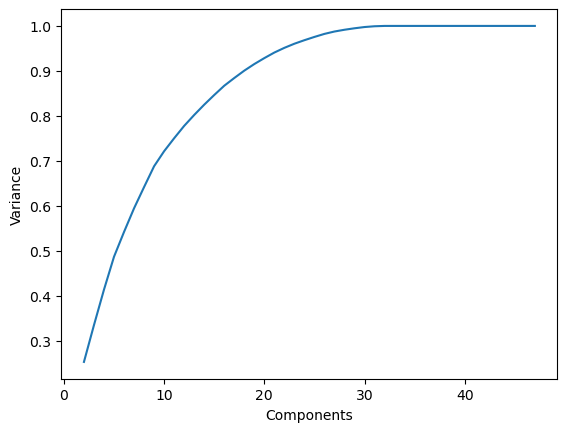

In [255]:
ax = sns.lineplot(data = results_df, x = 'Components', y = 'Variance')

In [14]:
# fit the PCA using train data
pca = PCA(n_components = 25)
train_cmpts = pca.fit_transform(X_train)

In [15]:
import pickle

with open('pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

In [16]:
train_cmpts.shape

(47, 25)

In [17]:
# transform the test data
test_cmpts = pca.transform(X_test)

In [18]:
print(train_cmpts.shape)
print(test_cmpts.shape)

(47, 25)
(12, 25)


# Model building

In [261]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [262]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [263]:
# Importing useful libraries
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import roc_auc_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import xgboost as xgb

# <font color = red>**XGBoost Classifier**</font>

In [188]:
def xgboost(train_x,train_y):

     xgb = XGBClassifier()

     # initializing with different combination of parameters
     param_grid_xgboost = {'tree_method': ['auto'],
                  "n_estimators": [10, 100, 120],
                  'booster' : ['dart', 'gbtree'],
#                   "criterion": ['gini', 'entropy'],
                  "max_depth": [2,3],
#                   "max_features": ['auto', 'log2'],
                  'objective': ['binary:logistic'],
#                   'lambda' : range(1e-4,10),
                  'alpha' : (1e-4,1),
                  'colsample_bytree' : (.1, .5),
                  'subsample' : (.1, 1)



             }

     # object for Grid Search cv
     grid= GridSearchCV(xgb, param_grid_xgboost, n_jobs= -1, verbose=3, cv=5,)

     # finding the best parameters
     grid.fit(train_x, train_y)

     # getting best parameters
     booster = grid.best_params_['booster']
     tree_method = grid.best_params_['tree_method']
     n_estimators = grid.best_params_['n_estimators']
#      criterion = grid.best_params_['criterion']
     max_depth = grid.best_params_['max_depth']
#      max_features = grid.best_params_['max_features']
     objective = grid.best_params_['objective']
#      lambda = grid.best_params_['lambda']
     alpha = grid.best_params_['alpha']
     colsample_bytree = grid.best_params_['colsample_bytree']
     subsample = grid.best_params_['colsample_bytree']


     # creating a new model with the best parameters
     xgb = XGBClassifier(booster=booster, tree_method=tree_method, n_estimators=n_estimators,
                                max_depth=max_depth, objective=objective, alpha=alpha,
                                colsample_bytree=colsample_bytree, subsample=subsample)

     # training the mew model
     xgb.fit(train_x, train_y)
     print('Best parameters for XGBoost: {}'.format (grid.best_params_))


     return xgb

In [189]:
xgb_classifier = xgboost(train_cmpts, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for XGBoost: {'alpha': 0.0001, 'booster': 'dart', 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 100, 'objective': 'binary:logistic', 'subsample': 1, 'tree_method': 'auto'}


In [192]:
xgb_classifier

XGBClassifier(alpha=0.0001, base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [193]:
xgb_classifier.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': 'dart',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 0.0001}

In [194]:
xgb_classifier.score(train_cmpts, y_train)

1.0

In [195]:
xgb_classifier.score(test_cmpts, y_test)

1.0

In [196]:
# Save the trained model to a file
import joblib
joblib.dump(xgb_classifier, 'xgb_model_25.pkl')

['xgb_model_25.pkl']

In [197]:
from sklearn.metrics import accuracy_score

# Assuming you have test data 'test_x' and corresponding labels 'test_y'
predictions = xgb_classifier.predict(test_cmpts)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [198]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[4 0]
 [0 8]]


In [199]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



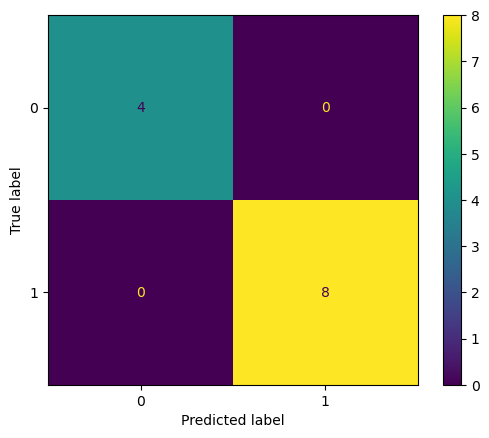

In [200]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

ConfusionMatrixDisplay.from_predictions(
   y_test, predictions)
plt.show()

In [201]:
y_test.shape

(12,)

In [202]:
y_test.value_counts()

activity_class
1    8
0    4
Name: count, dtype: int64

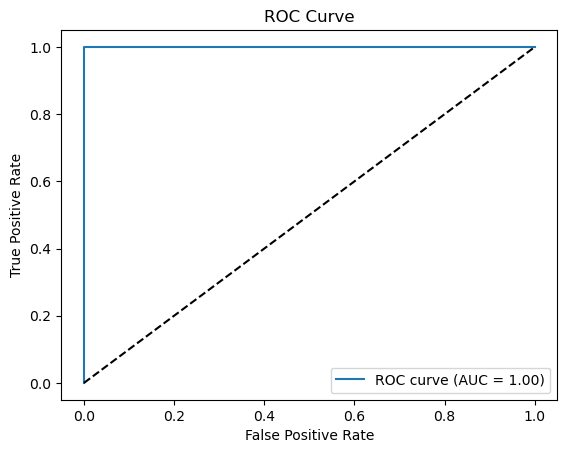

In [203]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have binary classification with probabilities
probs = xgb_classifier.predict_proba(test_cmpts)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# <font color = red>**KNN Classifier**</font>

In [204]:
def KNN(train_x, train_y):

    knn = KNeighborsClassifier()

    # Providing different combination of parameters
    param_grid_knn = {
        'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size' : [10,17,24,28,30,35],
        'n_neighbors':[4,5,8,10,11],
        'p':[1,2]

    }


    # Object for Grid Search cv
    grid = GridSearchCV(knn, param_grid_knn, n_jobs= -1, cv=10, verbose=3)

    # finding the best parameters
    grid.fit(train_x, train_y)

    # getting best parameters
    algorithm =grid.best_params_['algorithm']
    leaf_size = grid.best_params_['leaf_size']
    n_neighbors = grid.best_params_['n_neighbors']
    p  = grid.best_params_['p']

    # creating a new model with the best parameters
    knn = KNeighborsClassifier(algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, n_jobs=-1)

    # training the mew model
    knn.fit(train_x, train_y)
    print('Best Parameters for KNN: {}'.format(grid.best_params_))
    return knn


In [205]:
knn_classifier = KNN(train_cmpts, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best Parameters for KNN: {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 11, 'p': 1}


In [206]:
knn_classifier.score(train_cmpts, y_train)

0.9148936170212766

In [207]:
knn_classifier.score(test_cmpts, y_test)

0.9166666666666666

In [208]:
# Save the trained model to a file
import joblib
joblib.dump(knn_classifier, 'knn_model_25.pkl')

['knn_model_25.pkl']

In [209]:
from sklearn.metrics import accuracy_score

# Assuming you have test data 'test_x' and corresponding labels 'test_y'
predictions = knn_classifier.predict(test_cmpts)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


In [210]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[4 0]
 [1 7]]


In [211]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



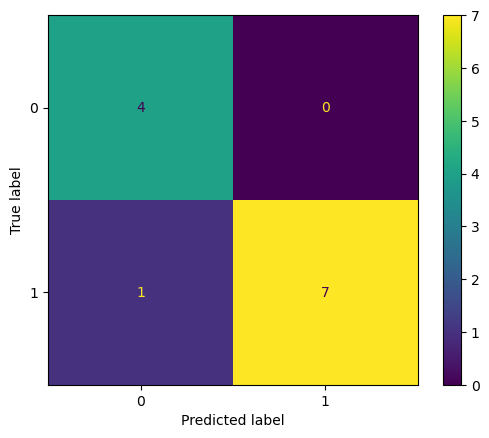

In [212]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

ConfusionMatrixDisplay.from_predictions(
   y_test, predictions)
plt.show()

In [19]:
import joblib

# <font color = red>**Random Forest Classifier**</font>

In [213]:
def random_forest(train_x,train_y):

    rfc = RandomForestClassifier()

    # Providing different combination of parameters
    param_grid = {"n_estimators": [10, 20, 30,50, 70, 100, 120],
                  "criterion": ['gini', 'entropy'],
                  "max_depth": range(2, 4, 1),
                  "max_features": ['sqrt', 'log2'],
                  "ccp_alpha" : (1e-4, 10)



                 }

    # object for GridSearchCV
    grid = GridSearchCV(rfc, param_grid=param_grid, n_jobs= -1, verbose=3, cv=10)

    #finding the best parameters
    grid.fit(train_x, train_y)

    #getting best parameters
    criterion = grid.best_params_['criterion']
    max_depth = grid.best_params_['max_depth']
    ccp_alpha = grid.best_params_['ccp_alpha']
    max_features = grid.best_params_['max_features']
    n_estimators = grid.best_params_['n_estimators']


    #create new model with best parameters
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                      max_depth=max_depth, ccp_alpha=ccp_alpha, max_features=max_features)
    # train new model
    rfc.fit(train_x, train_y)

    print('Best parameters for random forest are: {}'.format(grid.best_params_))

    return rfc


In [214]:
rfc_classifier = random_forest(train_cmpts, y_train)

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
Best parameters for random forest are: {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}


In [215]:
# Save the trained model to a file
import joblib
joblib.dump(rfc_classifier, 'rf_model_25.pkl')

['rf_model_25.pkl']

In [216]:
from sklearn.metrics import accuracy_score

# Assuming you have test data 'test_x' and corresponding labels 'test_y'
predictions = rfc_classifier.predict(test_cmpts)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8333333333333334


In [217]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[3 1]
 [1 7]]


In [218]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.88      0.88      0.88         8

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12



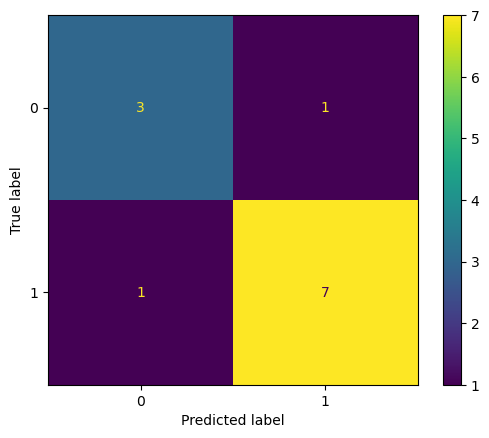

In [219]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

ConfusionMatrixDisplay.from_predictions(
   y_test, predictions)
plt.show()

# **SUPPORT VECTOR CLASSIFIER**

In [220]:
def support_vector(train_x, train_y):

    svc = SVC()

    # Providing different combination of parameters
    param_grid_svc = {
        'C': [0.1, 1, 10, 100], 
        'gamma': [0.001, 0.01, 0.1, 1], 
        'kernel': ['linear', 'rbf']
    }


    # Object for Grid Search cv
    grid = GridSearchCV(svc, param_grid_svc, n_jobs= -1, cv=10, verbose=3)

    # finding the best parameters
    grid.fit(train_x, train_y)

    # getting best parameters
    C =grid.best_params_['C']
    gamma = grid.best_params_['gamma']
    kernel = grid.best_params_['kernel']

    # creating a new model with the best parameters
    svc = SVC(C=C, gamma = gamma, kernel = kernel)

    # training the mew model
    svc.fit(train_x, train_y)
    print('Best Parameters for SVC: {}'.format(grid.best_params_))
    return svc


In [221]:
svc_classifier = support_vector(train_cmpts, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best Parameters for SVC: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


In [222]:
svc_classifier.score(train_cmpts, y_train)

0.9787234042553191

In [223]:
svc_classifier.score(test_cmpts, y_test)

0.9166666666666666

In [224]:
from sklearn.metrics import accuracy_score

# Assuming you have test data 'test_x' and corresponding labels 'test_y'
predictions = svc_classifier.predict(test_cmpts)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9166666666666666


In [225]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[4 0]
 [1 7]]


In [226]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12



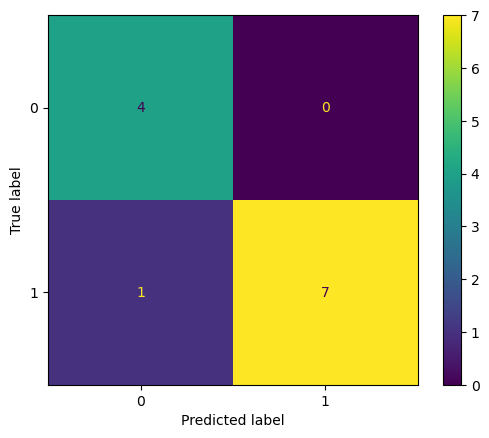

In [227]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

ConfusionMatrixDisplay.from_predictions(
   y_test, predictions)
plt.show()

In [228]:
y_test.value_counts()

activity_class
1    8
0    4
Name: count, dtype: int64

In [229]:
# Save the trained model to a file
import joblib
joblib.dump(svc_classifier, 'svm_model_25.pkl')

['svm_model_25.pkl']